In [1]:
#all_slow

# Tutorial: Fine-Tuning a Language Model on DataFrames with IMDB
> Tuning a base Language model on the IMDB dataset

## Introduction

In this tutorial we will be showing an end-to-end example of fine-tuning a Transformer language model on a custom dataset in `DataFrame` format.

By the end of this you should be able to:

1. Build a dataset with the `LanguageModelDatasets` class, and their DataLoaders
2. Build a `LanguageModelTuner` quickly, find a good learning rate, and train with the One-Cycle Policy
3. Save that model away, to be used with deployment or other HuggingFace libraries
4. Apply inference using both the `Tuner` available function as well as with the `EasyTextGenerator` class within AdaptNLP

## Installing the Library

This tutorial utilizies the latest AdaptNLP version, as well as parts of the `fastai` library. Please run the below code to install them:

In [2]:
# !git+https://github.com/novetta/adaptnlp@dev -U

In [3]:
#hide
from nbverbose.showdoc import *

## Getting the Dataset

First we need a dataset. We will use the `fastai` library to download the `IMDB_SAMPLE` dataset, a subset of IMDB Movie Reviews.

In [4]:
from fastai.data.external import URLs, untar_data

`URLs` holds a namespace of many data endpoints, and `untar_data` is a function that can download and extract any data from a given URL.

Combining both, we can download the data:

In [5]:
data_path = untar_data(URLs.IMDB_SAMPLE)

If we look at what was downloaded, we will find a `texts.csv` file:

In [6]:
data_path.ls()

(#1) [Path('/root/.fastai/data/imdb_sample/texts.csv')]

This is our data we want to use. We should now open the `csv` in `pandas` to generate our `DataFrame` object:

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv(data_path/'texts.csv')

Let's look at our data

In [9]:
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


We will find that there is a `label`, some `text`, and a `is_valid` boolean, which determines if a row is part of the training or the validation set

Now that we've downloaded some data, let's pick a viable model to train with

## Picking a Model with the Hub

AdaptNLP has a `HFModelHub` class that allows you to communicate with the HuggingFace Hub and pick a model from it, as well as a namespace `HF_TASKS` class with a list of valid tasks we can search by.

Let's try and find one suitable for sequence classification.

First we need to import the class and generate an instance of it:

In [10]:
from adaptnlp import HFModelHub, HF_TASKS

In [11]:
hub = HFModelHub()

Next we can search for a model:

In [12]:
models = hub.search_model_by_task(HF_TASKS.TEXT_GENERATION)

Let's look at a few:

In [13]:
models[:10]

[Model Name: distilgpt2, Tasks: [text-generation],
 Model Name: gpt2-large, Tasks: [text-generation],
 Model Name: gpt2-medium, Tasks: [text-generation],
 Model Name: gpt2-xl, Tasks: [text-generation],
 Model Name: gpt2, Tasks: [text-generation],
 Model Name: openai-gpt, Tasks: [text-generation],
 Model Name: transfo-xl-wt103, Tasks: [text-generation],
 Model Name: xlnet-base-cased, Tasks: [text-generation],
 Model Name: xlnet-large-cased, Tasks: [text-generation]]

These are models specifically tagged with the `text-generation` tag, so you may not see a few models you would expect such as `bert_base_cased`.

We'll use that first model, `distilgpt2`:

In [14]:
model = models[0]

In [15]:
model

Model Name: distilgpt2, Tasks: [text-generation]

Now that we have picked a model, let's use the data API to prepare our data

> Note: It should be mentioned that this is optional, you can always just pass in the string name of a model such as "bert-base-cased"

## Building `TaskDatasets` with `LanguageModelDatasets`

Each task has a high-level data wrapper around the `TaskDatasets` class. In our case this is the `LanguageModelDatasets` class:

In [16]:
from adaptnlp import LanguageModelDatasets

There are multiple different constructors for the `LanguageModelDatasets` class, and you should never call the main constructor directly.

We will be using `from_dfs`:

In [17]:
show_doc(LanguageModelDatasets.from_dfs)

<h4 id="LanguageModelDatasets.from_dfs" class="doc_header"><code>LanguageModelDatasets.from_dfs</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/language_model.py#L77" class="source_link" style="float:right">[source]</a></h4>

> <code>LanguageModelDatasets.from_dfs</code>(**`train_df`**:`DataFrame`, **`text_col`**:`str`, **`tokenizer_name`**:`str`, **`block_size`**:`int`=*`128`*, **`masked_lm`**:`bool`=*`False`*, **`valid_df`**:`DataFrame`=*`None`*, **`split_func`**:`callable`=*`None`*, **`split_pct`**:`float`=*`0.1`*, **`tokenize_kwargs`**:`dict`=*`{}`*, **`auto_kwargs`**:`dict`=*`{}`*)

Builds [`LanguageModelDatasets`](/adaptnlp/training.language_model.html#LanguageModelDatasets) from a `DataFrame` or file path

**Function Arguments**:
* `train_df` (`pd.DataFrame`): A Pandas Dataframe
* `text_col` (`str`): The name of the text column
* `tokenizer_name` (`str`): The name of the tokenizer
* `block_size` (`int`): The size of each block
* `masked_lm` (`bool`): Whether the language model is a MLM
* `valid_df` (`pd.DataFrame`): An optional validation DataFrame
* `split_func` (`callable`): Optionally a splitting function similar to RandomSplitter
* `split_pct` (`float`): What % to split the df between training and validation
* `tokenize_kwargs` (`dict`): kwargs for the tokenize function
* `auto_kwargs` (`dict`): kwargs for the AutoTokenizer.from_pretrained constructor


Anything you would normally pass to the tokenizer call (such as `max_length`, `padding`) should go in `tokenize_kwargs`, and anything going to the `AutoTokenizer.from_pretrained` constructor should be passed to the `auto_kwargs`.

In our case we only have a `train_df`, and since we are training a language model, we want to split the data 90/10 (which is the default)

Also, we will set a block_size of 128, and it is *not* a masked language model:

In [18]:
dsets = LanguageModelDatasets.from_dfs(
    train_df=df,
    text_col='text',
    tokenizer_name=model.name,
    block_size=128,
    masked_lm=False
)

No value for `max_length` set, automatically adjusting to the size of the model and including truncation
Sequence length set to: 1024


> Note: If you have a training and validation `DataFrame`, simply pass in the validation `DataFrame` as `valid_df=validation_dataframe` and do not pass in any `split_func` or `split_pct`. Everything else is the exact same

And finally turn it into some `AdaptiveDataLoaders`.

These are just fastai's `DataLoaders` class, but it overrides a few functions to have it work nicely with HuggingFace's `Dataset` class

In [19]:
show_doc(dsets.dataloaders)

<h4 id="TaskDatasets.dataloaders" class="doc_header"><code>TaskDatasets.dataloaders</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L246" class="source_link" style="float:right">[source]</a></h4>

> <code>TaskDatasets.dataloaders</code>(**`batch_size`**:`int`=*`8`*, **`shuffle_train`**:`bool`=*`True`*, **`collate_fn`**:`callable`=*`None`*, **`path`**=*`'.'`*, **`device`**=*`None`*)

Creates `DataLoaders` from the dataset

**Function Arguments**:
* `batch_size` (`int`): A batch size
* `shuffle_train` (`bool`): Whether to shuffle the training dataset
* `collate_fn` (`callable `): A custom collation function


In [20]:
dls = dsets.dataloaders(batch_size=8)

Finally, let's view a batch of data with the `show_batch` function:

In [21]:
dls.show_batch()

,Input,Label
0,"acknowledge the real essence of what makes them the modern day Puerto Ricans,but barely mentioned how Africans influenced the way their Spanish is spoken, the food and music. She is so typical and I lost a lot of respect for her and will not support anything else she does. Also, since she wants to dance around her African-ness then she need not take more roles associated with blackness (i.e. Lackawanna Blues). We can find a prideful Black Latina next time (thank you Zoe Saldana,Gina Torres, Gina Ravera and Melissa DeSousa).<br /><br />To the Puerto Rican on here that said they are African and not ""black""....thank you. We ""blacks"" certainly do not have anything in common with ""you"" so there is no love lost. But, since you are probably in the States and have benefited from the Civil Rights movement we would like for you refuse any decent human treatment you received courtesy of the blood,sweat and tears from the backs of the ""blacks"" you share nothing with.<br /><br />If I am correct Puerto Ricans have a terrible image in the media, but we blacks do not spend our time trying to disrespect you because we know that the media loves to exploits the low points and behaviors of all minorities to maintain mindless generalizations. However, you evidently have fed into the hype that one you are somehow white or superior...you are not. Also, you somehow feel compelled to believe that black culture is BET...again you are incorrect and need to take a vacation out of the hood. Try visiting Atlanta, Ga., Houston, Texas, Charlotte, N.C. Trust me none of those blacks want to claim your ""culture"" either.I think James Cameron might be becoming my favorite director because this is my second review of his movies. Anyway, everyone remembers the RMS Titanic. It was big, fast, and ""unsinkable""... until April 1912. It was all over the news and one of the biggest tragedies ever. Well James Cameron decided to make a movie out of it but star two fictional characters to be in the spotlight instead of the ship. Well, onto the main review but let me remind you that this is all opinion and zero fact and the only fact that will be present is an event from the film.<br /><br />So our two main characters are Jack (Leonardo DiCaprio) and Rose (Kate Winslet). They're not annoying too much but","acknowledge the real essence of what makes them the modern day Puerto Ricans,but barely mentioned how Africans influenced the way their Spanish is spoken, the food and music. She is so typical and I lost a lot of respect for her and will not support anything else she does. Also, since she wants to dance around her African-ness then she need not take more roles associated with blackness (i.e. Lackawanna Blues). We can find a prideful Black Latina next time (thank you Zoe Saldana,Gina Torres, Gina Ravera and Melissa DeSousa).<br /><br />To the Puerto Rican on here that said they are African and not ""black""....thank you. We ""blacks"" certainly do not have anything in common with ""you"" so there is no love lost. But, since you are probably in the States and have benefited from the Civil Rights movement we would like for you refuse any decent human treatment you received courtesy of the blood,sweat and tears from the backs of the ""blacks"" you share nothing with.<br /><br />If I am correct Puerto Ricans have a terrible image in the media, but we blacks do not spend our time trying to disrespect you because we know that the media loves to exploits the low points and behaviors of all minorities to maintain mindless generalizations. However, you evidently have fed into the hype that one you are somehow white or superior...you are not. Also, you somehow feel compelled to believe that black culture is BET...again you are incorrect and need to take a vacation out of the hood. Try visiting Atlanta, Ga., Houston, Texas, Charlotte, N.C. Trust me none of those blacks want to claim your ""culture"" either.I think James Cameron might be becoming my favorite 

When training a language model, the input and output are made to be the exact same, so there isn't a shown noticable difference here.

## Building `Tuner`

Next we need to build a compatible `Tuner` for our problem. These tuners contain good defaults for our problem space, including loss functions and metrics.

First let's import the `LanguageModelTuner` and view it's documentation

In [22]:
from adaptnlp import LanguageModelTuner

In [23]:
show_doc(LanguageModelTuner)

<h2 id="LanguageModelTuner" class="doc_header"><code>class</code> <code>LanguageModelTuner</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/language_model.py#L224" class="source_link" style="float:right">[source]</a></h2>

> <code>LanguageModelTuner</code>(**`dls`**:`DataLoaders`, **`model_name`**, **`tokenizer`**=*`None`*, **`language_model_type`**:`LMType`=*`'causal'`*, **`loss_func`**=*`CrossEntropyLoss()`*, **`metrics`**=*`[<fastai.metrics.Perplexity object at 0x7f8c5c968130>]`*, **`opt_func`**=*`Adam`*, **`additional_cbs`**=*`None`*, **`expose_fastai_api`**=*`False`*, **\*\*`kwargs`**) :: [`AdaptiveTuner`](/adaptnlp/training.core.html#AdaptiveTuner)

An [`AdaptiveTuner`](/adaptnlp/training.core.html#AdaptiveTuner) with good defaults for Language Model fine-tuning
**Valid kwargs and defaults:**
  - `lr`:float = 0.001
  - `splitter`:function = `trainable_params`
  - `cbs`:list = None
  - `path`:Path = None
  - `model_dir`:Path = 'models'
  - `wd`:float = None
  - `wd_bn_bias`:bool = False
  - `train_bn`:bool = True
  - `moms`: tuple(float) = (0.95, 0.85, 0.95)

**Function Arguments**:
* `dls` (`DataLoaders`): A set of DataLoaders or AdaptiveDataLoaders
* `model_name`: A HuggingFace model
* `language_model_type` (`LMType `): The type of language model to use
* `**kwargs`: kwargs for `Learner.__init__`
* `**kwargs`: Optional arguments for `PretrainedModel.generate`


Next we'll pass in our `DataLoaders`, the name of our model, and the tokenizer:

> Note: If you are **not** using the data API and generating `AdaptiveDataLoaders`, you need to pass in the tokenizer to the constructor as well with `tokenizer=tokenizer`

In [24]:
tuner = LanguageModelTuner(dls, model.name, dls.tokenizer)

By default we can see that it used `CrossEntropyLoss` as our loss function, and `Perplexity` as our metric

In [25]:
tuner.loss_func

FlattenedLoss of CrossEntropyLoss()

In [26]:
_ = [print(m.name) for m in tuner.metrics]

perplexity


Finally we just need to train our model!

## Fine-Tuning

To fine-tune, AdaptNLP's tuner class provides only a few functions to work with. The important ones are the `tune` and `lr_find` class.

As the `Tuner` uses `fastai` under the hood, `lr_find` calls fastai's Learning Rate Finder to help us pick a learning rate. Let's do that now:

In [27]:
show_doc(tuner.lr_find)

<h4 id="AdaptiveTuner.lr_find" class="doc_header"><code>AdaptiveTuner.lr_find</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L383" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.lr_find</code>(**`start_lr`**=*`1e-07`*, **`end_lr`**=*`10`*, **`num_it`**=*`100`*, **`stop_div`**=*`True`*, **`show_plot`**=*`True`*, **`suggest_funcs`**=*`valley`*)

Runs fastai's `LR Finder`



/opt/venv/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0003311311302240938)

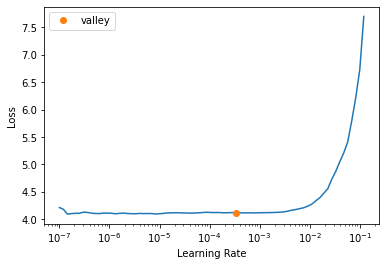

In [28]:
tuner.lr_find()

It recommends a learning rate of around 5e-5, so we will use that.

In [29]:
lr = 5e-5

Let's look at the documentation for `tune`:

In [30]:
show_doc(tuner.tune)

<h4 id="AdaptiveTuner.tune" class="doc_header"><code>AdaptiveTuner.tune</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L369" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.tune</code>(**`epochs`**:`int`, **`lr`**:`float`=*`None`*, **`strategy`**:`Strategy`=*`'fit_one_cycle'`*, **`callbacks`**:`list`=*`[]`*, **\*\*`kwargs`**)

Fine tune `self.model` for `epochs` with an `lr` and `strategy`



We can pass in a number of epochs, a learning rate, a strategy, and additional fastai callbacks to call.

Valid strategies live in the `Strategy` namespace class, and consist of:
- OneCycle
- CosineAnnealing
- SGDR

In [31]:
from adaptnlp import Strategy

In this tutorial we will train with the One-Cycle policy.

In [32]:
tuner.tune(3, lr, strategy=Strategy.OneCycle)

epoch,train_loss,valid_loss,perplexity,time
0,4.060410,3.894190,49.116245,00:56
1,3.961307,3.877189,48.288303,00:55
2,3.893311,3.877568,48.306591,00:54


## Saving Model

Now that we have a trained model, let's save those weights away.

Calling `tuner.save` will save both the model and the tokenizer in the same format as how HuggingFace does:

In [33]:
show_doc(tuner.save)

<h4 id="AdaptiveTuner.save" class="doc_header"><code>AdaptiveTuner.save</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/core.py#L391" class="source_link" style="float:right">[source]</a></h4>

> <code>AdaptiveTuner.save</code>(**`save_directory`**)

Save a pretrained model to a `save_directory`

**Function Arguments**:
* `save_directory`: A folder to save our model to


In [34]:
tuner.save('good_model')

'good_model'

## Performing Inference

There are two ways to get predictions, the first is with the `.predict` method in our `tuner`. This is great for if you just finished training and want to see how your model performs on some new data!
The other method is with AdaptNLP's inference API, which we will show afterwards

### In Tuner

First let's write a sentence to test with

In [35]:
sentence = "Hugh Jackman is a terrible "

And then predict with it:

In [36]:
show_doc(tuner.predict)

<h4 id="LanguageModelTuner.predict" class="doc_header"><code>LanguageModelTuner.predict</code><a href="https://github.com/novetta/adaptnlp/tree/master/adaptnlp/training/language_model.py#L289" class="source_link" style="float:right">[source]</a></h4>

> <code>LanguageModelTuner.predict</code>(**`text`**:`Union`\[`List`\[`str`\], `str`\], **`bs`**:`int`=*`64`*, **`num_tokens_to_produce`**:`int`=*`50`*, **\*\*`kwargs`**)

Predict some `text` for sequence classification with the currently loaded model

**Function Arguments**:
* `text` (`Union[List[str], str]`): Some text or list of texts to do inference with
* `bs` (`int`): A batch size to use for multiple texts
* `num_tokens_to_produce` (`int`): Number of tokens to generate
* `**kwargs`: Optional arguments for `PretrainedModel.generate`


In [37]:
tuner.predict(sentence, num_tokens_to_produce=8)

{'generated_text': ['Hugh Jackman is a terrible icky, and very funny, character.']}

### With the Inference API

Next we will use the `EasyTextGenerator` class, which AdaptNLP offers:

In [38]:
from adaptnlp import EasyTextGenerator

We simply construct the class:

In [39]:
classifier = EasyTextGenerator()

And call the `tag_text` method, passing in the sentence, the location of our saved model, and some names for our classes:

In [41]:
classifier.generate(
    sentence,
    model_name_or_path='good_model',
    num_tokens_to_produce=8
)

{'generated_text': ['Hugh Jackman is a terrible icky, and very funny, character.']}

And we got the exact same output!